# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [ ]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [ ]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [ ]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [ ]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [ ]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [ ]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [ ]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

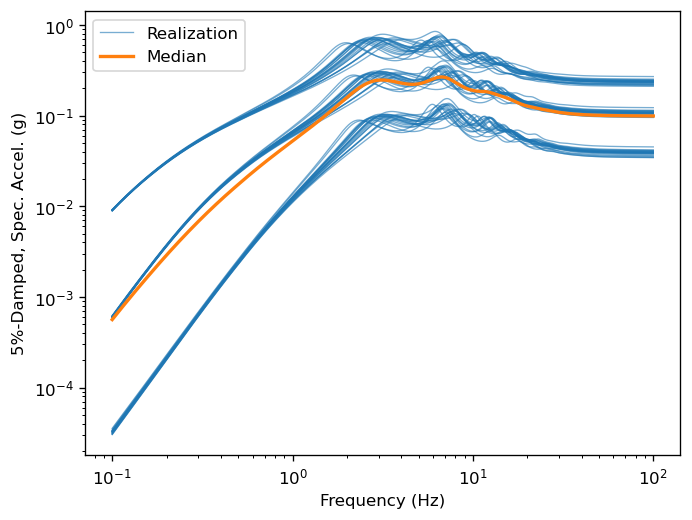

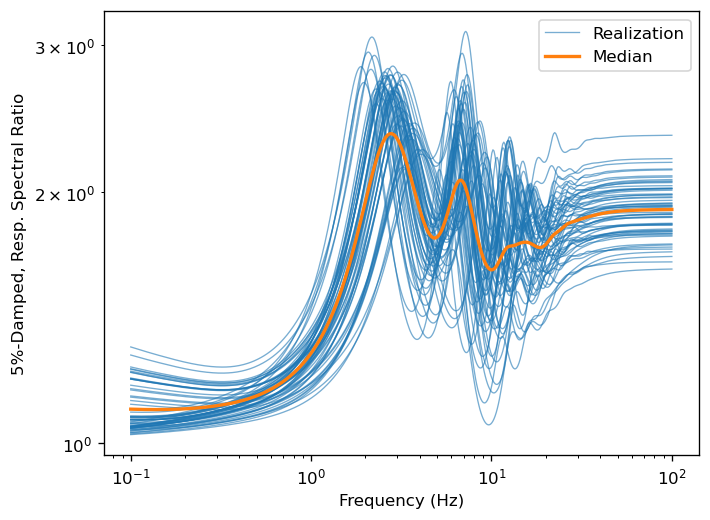

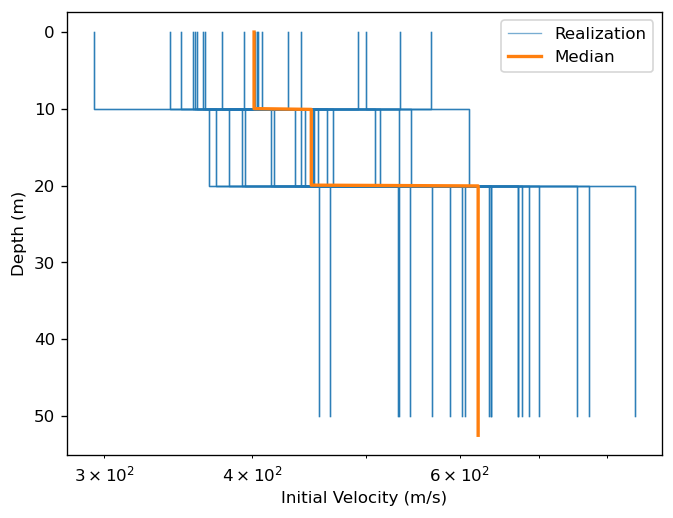

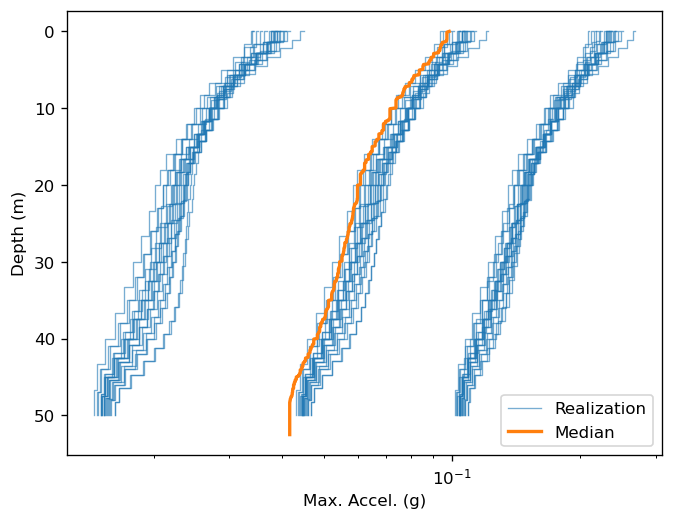

In [ ]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [ ]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.215102  1.072566  1.045659  1.173128  1.059268  1.037130   
0.101394    1.214359  1.072509  1.046010  1.172593  1.059232  1.037422   
0.102807    1.213617  1.072457  1.046365  1.172059  1.059201  1.037717   
0.104240    1.212878  1.072410  1.046723  1.171528  1.059175  1.038015   
0.105693    1.212143  1.072369  1.047086  1.170998  1.059154  1.038316   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.018532  1.925903  1.800422  2.021510  1.925387  1.834116   
95.932095   2.018608  1.925975  1.800516  2.021567  1.925436  1.834184   
97.269336   2.018682  1.926045  1.800607  2.021623  1.925483  1.834251   
98.625218   2.018753  1.926113  1.800695  2.021677  1.925528  1.834315   
100.000000  2.018823  1.926178  1.800780  2.021729  1.925572  1.834378   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.124558  1.042159  1.025642  1.138836  ...  1.042062  1.216202   
0.101394    1.124200  1.042144  1.025849  1.138458  ...  1.042389  1.215414   
0.102807    1.123842  1.042132  1.026059  1.138081  ...  1.042719  1.214629   
0.104240    1.123486  1.042124  1.026271  1.137705  ...  1.043053  1.213846   
0.105693    1.123132  1.042121  1.026485  1.137331  ...  1.043390  1.213067   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.781856  1.708196  1.648736  2.034847  ...  1.907360  1.790782   
95.932095   1.781884  1.708214  1.648765  2.034882  ...  1.907442  1.790868   
97.269336   1.781911  1.708231  1.648792  2.034917  ...  1.907520  1.790951   
98.625218   1.781938  1.708248  1.648818  2.034950  ...  1.907597  1.791032   
100.000000  1.781963  1.708264  1.648844  2.034982  ...  1.907671  1.791110   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.072003  1.044762  1.275056  1.089119  1.054889  1.233685   
0.101394    1.071944  1.045107  1.273968  1.089030  1.055305  1.232835   
0.102807    1.071890  1.045456  1.272884  1.088947  1.055725  1.231988   
0.104240    1.071842  1.045809  1.271803  1.088871  1.056150  1.231144   
0.105693    1.071799  1.046166  1.270727  1.088801  1.056579  1.230303   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.732230  1.616196  1.985476  1.881364  1.694967  2.061525   
95.932095   1.732313  1.616295  1.985556  1.881452  1.695075  2.061597   
97.269336   1.732394  1.616391  1.985635  1.881538  1.695180  2.061667   
98.625218   1.732472  1.616484  1.985710  1.881621  1.695281  2.061734   
100.000000  1.732548  1.616575  1.985784  1.881702  1.695379  2.061800   

                                
                  m1        m2  
0.100000    1.077714  1.048451  
0.101394    1.077647  1.048822  
0.102807    1.077586  1.049197  
0.104240    1.077531  1.049576  
0.105693    1.077481  1.049958  
...              ...       ...  
94.613238   1.954123  1.805496  
95.932095   1.954196  1.805590  
97.269336   1.954266  1.805682  
98.625218   1.954335  1.805771  
100.000000  1.954401  1.805858  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [ ]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.melt(ignore_index=False).reset_index().set_index(["freq", "profile", "motion"])
df

,,,value
freq,profile,motion,
0.100000,p0,m0,1.215102
0.101394,p0,m0,1.214359
0.102807,p0,m0,1.213617
0.104240,p0,m0,1.212878
0.105693,p0,m0,1.212143
...,...,...,...
94.613238,p19,m2,1.805496
95.932095,p19,m2,1.805590
97.269336,p19,m2,1.805682


In [ ]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(level=["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.193696  0.039370
           m1      1.065453  0.013850
           m2      1.040955  0.008915
0.101394   m0      1.193050  0.039199
           m1      1.065406  0.013829
...                     ...       ...
98.625218  m1      1.912448  0.058332
           m2      1.800170  0.057490
100.000000 m0      2.009889  0.064886
           m1      1.912500  0.058332
           m2      1.800241  0.057487

[1500 rows x 2 columns]

In [ ]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.039370  1.193696  0.013850  1.065453  0.008915  1.040955
0.101394    0.039199  1.193050  0.013829  1.065406  0.008976  1.041273
0.102807    0.039029  1.192406  0.013808  1.065364  0.009037  1.041594
0.104240    0.038859  1.191764  0.013788  1.065327  0.009098  1.041918
0.105693    0.038690  1.191125  0.013769  1.065295  0.009161  1.042245
...              ...       ...       ...       ...       ...       ...
94.613238   0.064891  2.009649  0.058331  1.912280  0.057499  1.799941
95.932095   0.064890  2.009712  0.058331  1.912337  0.057496  1.800020
97.269336   0.064889  2.009773  0.058332  1.912393  0.057493  1.800096
98.625218   0.064888  2.009832  0.058332  1.912448  0.057490  1.800170
100.000000  0.064886  2.009889  0.058332  1.912500  0.057487  1.800241

[500 rows x 6 columns]

Access the properties of each motion like:

In [ ]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.039370,1.193696
0.101394,0.039199,1.193050
0.102807,0.039029,1.192406
0.104240,0.038859,1.191764
0.105693,0.038690,1.191125
...,...,...
94.613238,0.064891,2.009649
95.932095,0.064890,2.009712
97.269336,0.064889,2.009773


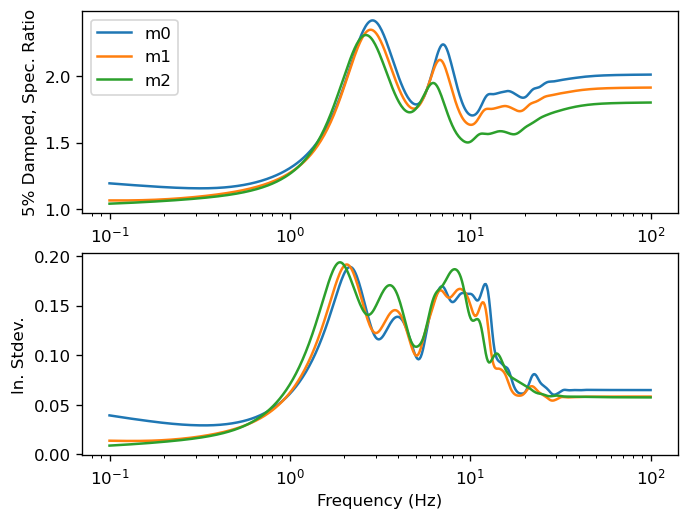

In [ ]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.T.groupby(level=0):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.columns, g.loc[name, key], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;